## 1. Loading data

We start by importing the libraries we need: 
- sklearn and numpy to do machine learning, 
- csv and pickle read the data and write out submission and model files, 
- time and os to keep organized with the files we output,
- matplotlib to perform visualizations.
We also import some specific sklearn components as well as an utils library with some handy extra functions.

In [1]:
import sklearn
import numpy as np
import csv
import pickle
import time
import os
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV

import utils_for_students

In [2]:
train_samples = utils_for_students.load_dataset_stage2('../data/stage2_labels_train.csv', 'train')
test_samples = utils_for_students.load_dataset_stage2('../data/stage2_ids_test.csv', 'test')

In [3]:
train_samples[0].keys()

dict_keys(['path', 'id', 'label', 'signer'])

In [4]:
sample = train_samples[0]

landmark_sequence = utils_for_students.load_sample_stage2(os.path.join('../data/stage2/train/', sample['path']))

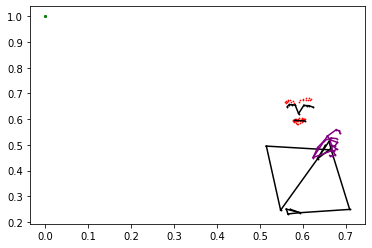

In [5]:
FRAME_INDEX = 0

utils_for_students.visualize_pose(landmark_sequence[FRAME_INDEX], plt)

In order to get a better grasp of every class in the dataset, we provide some additional information here.

There are 15 different classes. Each class corresponds to a sign. Signs can be annotated using sign glosses, which are representations of signs in written form in a spoken language. In the below table, we list all glosses, the English meaning of the corresponding sign, and provide a link to the Flemish sign language dictionary so that you can see an example performance of that sign.

| Gloss             | English meaning | Dictionary URL                                                                                        |
|-------------------|-----------------|-------------------------------------------------------------------------------------------------------|
| c.AF              | Done, finished  | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/AF/AF-B-209.mp4          |
| c.OOK             | Too, also       | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/OO/OOK-A-8491.mp4        |
| ZELFDE-A          | The same        | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/ZE/ZELFDE-A-14290.mp4    |
| AUTO-RIJDEN-A     | To drive a car  | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/RI/RIJDEN-C-9982.mp4     |
| HEBBEN-A          | To have         | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/HE/HEBBEN-A-4801.mp4     |
| HAAS-oor          | Hare            | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/HA/HAAS-B-16147.mp4      |
| AANKOMEN-A        | To arrive       | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/AA/AANKOMEN-A-39.mp4     |
| SCHILDPAD-Bhanden | Turtle          | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/SC/SCHILDPAD-A-10503.mp4 |
| WAT-A             | What            | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/WA/WAT-A-13657.mp4       |
| c.ZIEN            | To see          | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/BE/BEKIJKEN-A-1157.mp4   |
| NAAR-A            | Towards         | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/GA/GA-NAAR-A-4032.mp4    |
| MOETEN-A          | To must         | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/MO/MOETEN-D-17652.mp4    |
| C: 1              | 1               | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/1-/1-A-15277.mp4         |
| GOED-A            | Good            | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/GO/GOED-C-4413.mp4       |
| C: 2              | 2               | https://vlaamsegebarentaal.be/signbank/dictionary/protected_media/glossvideo/2-/2-A-15278.mp4         |

## 3. Feature Extraction

For stage 1, we performed feature extraction for you.

In this stage, you will need to perform feature extraction yourself.

In [6]:
from utils_feature_preprocessing import split_features_into_frames

def extract_features(pose_sequence):
    # You should implement this function to return better features!
    
    pose_sequence = split_features_into_frames(pose_sequence, k=4)
    
    return pose_sequence

In [7]:
# Concatenate the training set features.
X_train = []
y_train = []
signers_train = []
for sample in train_samples:
    pose_sequence = utils_for_students.load_sample_stage2(os.path.join('../data/stage2/train/', sample['path']))
    X_train.append(extract_features(pose_sequence))
    y_train.append(sample['label'])
    signers_train.append(sample['signer'])
    
# Concatenate the test set features.
X_test = []
test_ids = []
for sample in test_samples:
    pose_sequence = utils_for_students.load_sample_stage2(os.path.join('../data/stage2/test/', sample['path']))
    X_test.append(extract_features(pose_sequence))
    test_ids.append(sample['id'])

#Combining to numpy array
X_train = np.stack(X_train)
X_test = np.stack(X_test)

# Encode the labels as integers
label_encoder = utils_for_students.label_encoder()
y_train = label_encoder.transform(y_train)

In [8]:
print(X_train.shape, y_train.shape)
print(X_test.shape)

(2191, 1500) (2191,)
(541, 1500)


## 4. Creating pipelines for preprocessing and feature selection 

Now, we are ready to define our pipelines. You can create the same pipeline as for stage 1 as a baseline, but you will be expected to tune both the feature engineering
and pipeline parts of your model iteratively to improve your results.

In [9]:
# TODO: define preprocessing pipeline here
# It is up to you to define the number of modules in each pipeline and their types
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest,SelectFromModel,VarianceThreshold, RFE, f_classif, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

#chosen PCA instead of LDA as the n_components of LDA has to be <= min(n_classes - 1, n_features) which is 14 in
#this case (down from 750). Which is likely to little given the that the features are only x, y or z values.
preprocessing = Pipeline([
    ('normalizer', Normalizer()),
    ('scaler', StandardScaler()),
    ('decompose', PCA()),
    ('rescale', StandardScaler()),
                        ]) 

#TODO: define feature selection pipeline here
#first we remove the features that mithingsght lead to false results
#then we use selectFromModel to assign weights and take the least important features away for generalization
#ofcourse only using linear regression models (the same model as the actual classifier)
feature_selection = Pipeline([
    ('selectKBest', SelectKBest()),
                            ]) 

## 5. Define a suitable classifier
With your preprocessing and feature selection in place, it is now time to define the final element: a suitable classifier. 

In [10]:
from sklearn.linear_model import RidgeClassifier

#TODO: define proper classifier
classifier = RidgeClassifier(fit_intercept=False)

## 6. Set up hyperparameter grid for [GridsearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) object.

Now, define your GridSearchCV hyperparameter grid and object.


In [11]:
#param grid has been set to some constants because this is not subject of optimization in this notebook
param_grid = {
    #'feature_selection__selectFWE__score_func': [chi2, f_classif, mutual_info_classif],
    #'feature_selection__selectFWE__alpha': [0.15],#[1e-2, 2.5e-2, 5e-2, 1e-1, 1.5e-1, 2e-1, 3e-1, 5e-1, 6e-1, 6.5e-1, 7e-1, 9e-1, 9.9e-1, 1],
    #'feature_selection__selectFromModel__threshold': ["1.2*mean"],#["0.25*mean", "0.75*mean", "1*mean", "1.2*mean", "1.25*mean", "1.5*mean", "0.5*median", "0.75*median", "1*median", "1.25*median", "2*median", "2.05*median", "2.1*median", "2.2*median"],
    #'preprocessing__decompose__n_components': ['mle'],#['mle', 140, 150, 160, 170, 180, 190, 200, 300, 400, 500, 600, 700],
    'feature_selection__selectKBest__score_func': [f_classif],# mutual_info_classif],
    'feature_selection__selectKBest__k': [140],#[50,60,70,80,90,100,105,110,115, 120, 140, 145, 150, 155, 160, 180, 200,220,240,260,280,550,600,610,620,630],
    'classifier__alpha': [1],#[1e9, 1e8, 1e7, 1e6, 1e5, 1e4, 1e3, 1e2, 1],
    #'classifier__C': [1.0e-6, 1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1, 1.0],
    'classifier__tol': [1.0e-5],#[1.0e-5, 1.0e-4,  1.0e-2, 1.0e-1, 0.2, 0.5, 0.7, 0.9],
    'classifier__class_weight': ['balanced'],#['balanced', None]
 }

## 7. Define the number of crossvaldation folds and how to split

Now, you should define the number of CV folds and how to split the data.
Assuming you had a correct split in the first stage of the competition, you can re-use the same code.


In [12]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold

#TODO: set appropriate number of cv folds
n_folds = 4  

# The function below is just an example!
#TODO: write a better split function here?
def create_folds(X,y,n_folds):
    folds = []
    cv_object = StratifiedGroupKFold(n_splits = n_folds)
    for (train_indices, val_indices) in  cv_object.split(X_train, y_train, groups=signers_train):
        folds.append((train_indices,val_indices))
    return folds

## 8. Training the model
Now it is time to put everything together and train the model. As you can see, `GridsearchCV` takes the pipelines as well as the classifier and the hyperparameter dictionary you defined, and uses `create_folds` to create list of train and test indices for each split. Then the model is trained using `cv.fit()` and the model and submission files are written to the file system.

In stage 2, this cell is no longer locked and you are free to edit it as you like.

In [13]:
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('feature_selection', feature_selection),
    ('classifier', classifier)])

folds = create_folds(X_train,y_train,n_folds)
assert isinstance(folds,list),'Folds must be presented as tuples of train and test index lists' 

# train model
cv = GridSearchCV(pipeline, param_grid, n_jobs=4, cv=folds, verbose=1, return_train_score=True, refit=True)
cv.fit(X_train, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


GridSearchCV(cv=[(array([   0,    1,    2, ..., 2187, 2189, 2190]),
                  array([   4,    6,   12,   13,   16,   21,   29,   43,   49,   58,   60,
         65,   70,   73,   74,   81,   85,   86,   89,   91,   92,  100,
        102,  103,  104,  105,  107,  109,  121,  122,  124,  126,  127,
        130,  150,  154,  159,  163,  164,  170,  172,  178,  181,  182,
        199,  204,  207,  208,  209,  212,  213,  220,  222,  226,  229,
        237,  242,  246,  253,  254,  264,  267,  275,  278,  279,  283,
        284,  290,  299,  300,  305,  309,  313,  314,  317,  318,  320,
        322,  32...
                                        Pipeline(steps=[('selectKBest',
                                                         SelectKBest())])),
                                       ('classifier',
                                        RidgeClassifier(fit_intercept=False))]),
             n_jobs=4,
             param_grid={'classifier__alpha': [1],
                         '

## 9. Printing scores
Here we simply extract a bit more information about the individual scores obtained by the classifers we trained to fit the individual folds. Maybe a few plots may be useful to better understand what your classifier is doing? 

In [14]:
results = cv.cv_results_
mean_train_score = results['mean_train_score'][cv.best_index_]
std_train_score = results['std_train_score'][cv.best_index_]
mean_cv_score = results['mean_test_score'][cv.best_index_]
std_cv_score = results['std_test_score'][cv.best_index_]

print('Training accuracy {} +/- {}'.format(mean_train_score, std_train_score))
print('Cross-validation accuracy: {} +/- {}'.format(mean_cv_score, std_cv_score))

print('Best estimator:')
print(cv.best_estimator_)

Training accuracy 0.8453533274066934 +/- 0.012701979286660734
Cross-validation accuracy: 0.6024587264733258 +/- 0.03546073157867271
Best estimator:
Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('normalizer', Normalizer()),
                                 ('scaler', StandardScaler()),
                                 ('decompose', PCA()),
                                 ('rescale', StandardScaler())])),
                ('feature_selection',
                 Pipeline(steps=[('selectKBest', SelectKBest(k=140))])),
                ('classifier',
                 RidgeClassifier(alpha=1, class_weight='balanced',
                                 fit_intercept=False, tol=1e-05))])


## 10. Confusion matrix

In [15]:
from utils_for_students import label_encoder

CLASSES = label_encoder().inverse_transform([i for i in range(len(label_encoder().classes_))])

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, title):
    fig = plt.figure(figsize = (15,15))
    ax = fig.gca()
    ax.set_title(title)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
    disp.plot(include_values=True, ax=ax)
    plt.xticks(rotation=45, ha="right")
    plt.show()


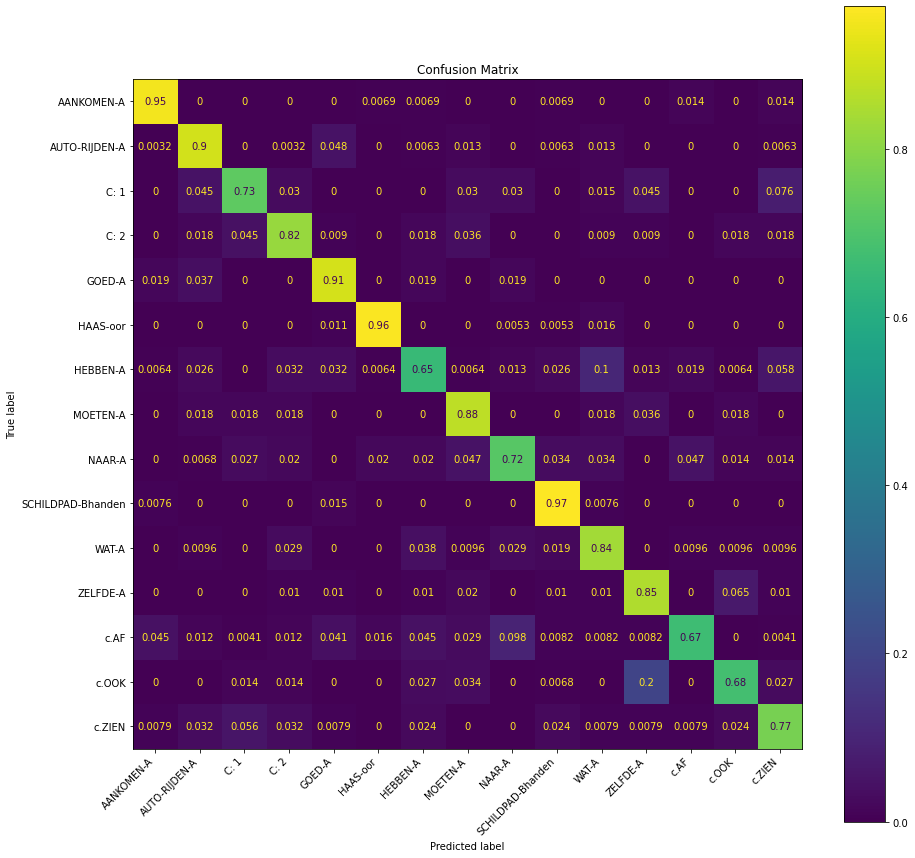

Correct prediction %:  0.8183


In [20]:
# Confusion matrix of whole set
y_pred = cv.best_estimator_.predict(X_train)
plot_confusion_matrix(confusion_matrix(y_train, y_pred, normalize='true'), 'Confusion Matrix')

matrix = confusion_matrix(y_train, y_pred)
print("Correct prediction %: ", round(np.sum(np.diagonal(matrix))/np.sum(matrix),4))

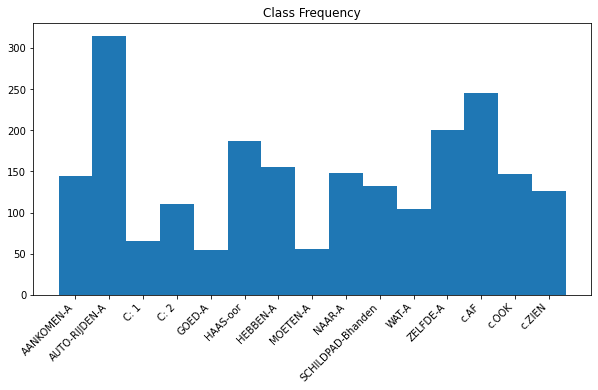

In [18]:
from matplotlib import pyplot as plt
import pandas as pd

plt.figure(figsize = (10,5))
data_class = pd.DataFrame(label_encoder().inverse_transform(y_train))
unique, counts = np.unique(data_class, return_counts=True)
plt.bar(unique, counts, 1)
plt.title('Class Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()